In [71]:
%matplotlib notebook

In [1]:
import numpy as np
#import nest
import sklearn.metrics
import matplotlib.pyplot as plt
import scipy.stats
import scipy
import array
import collections
from scipy.linalg import expm
import random

In [2]:
senders = np.load("sp_senders-10e7-ms.npy")
times = np.load("sp_times-10e7-ms.npy")

In [3]:
spikes = np.histogram2d(senders, times, bins=[range(1, 1252), np.arange(0, 10000000+1, 1)])[0]

In [4]:
np.save("spikes-10e7-ms-bin1.npy", spikes)

In [2]:
spikes = np.load("spikes-60e6-ms.npy")

In [3]:
np.shape(spikes)

(1250, 6000000)

In [93]:
a = np.array([[1, 2], [-.5, 0]])
b = scipy.linalg.logm(a)
b

array([[ 0.60459979,  2.41839915],
       [-0.60459979, -0.60459979]])

In [75]:
c = scipy.linalg.expm(b)
c

array([[ 1.00000000e+00,  2.00000000e+00],
       [-1.00000000e+00, -1.53353343e-16]])

In [97]:
import math
math.log(-12)

ValueError: math domain error

In [307]:
G = np.load('connectivity-60e6-ms.npy')
A = np.load('est-60e6-tau100-ds1.npy')

#conl = scipy.linalg.logm(G)
#estl = scipy.linalg.logm(A)

cone = scipy.linalg.expm(1e-3*G)

#conl = conl - (np.diag(np.diag(conl)))
#estl = estl - (np.diag(np.diag(estl)))

#conlR = np.real(conl)
#conlI = np.imag(conl)
#estR = np.real(estl)
#estI = np.imag(estl)

#cone = scipy.linalg.expm(conl)
#este = scipy.linalg.expm(estl)

<IPython.core.display.Javascript object>


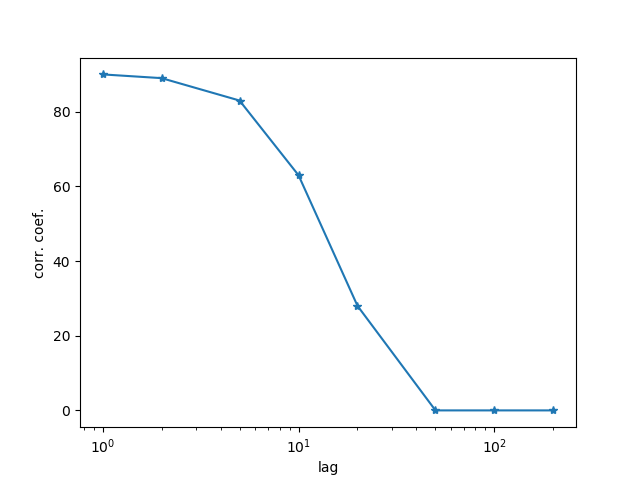

In [304]:
a = np.array([1,2,5,10,20,50,100,200])
b = np.array([90,89,83,63,28,0,0,0])
plt.figure()
plt.plot(a, b, "*-")
plt.xscale('log')
plt.xlabel('lag')
plt.ylabel('corr. coef.')
plt.show()

In [271]:

np.count_nonzero(cone)

1562500

In [264]:
G = G - (np.diag(np.diag(G)))
estl = estl - (np.diag(np.diag(estl)))
A = A - (np.diag(np.diag(A)))

In [265]:
estR = estR - (np.diag(np.diag(estR)))
estI = estI - (np.diag(np.diag(estI)))
conlR = conlR - (np.diag(np.diag(conlR)))
conlI = conlI - (np.diag(np.diag(conlI)))

In [275]:
cone

array([[ 1.02836842, -0.06520583,  0.00405684, ..., -0.1306679 ,
         0.38887997, -0.03463912],
       [ 0.0667846 ,  0.92623979,  0.1159677 , ...,  0.38500993,
         0.18942544,  0.24748787],
       [ 0.02877512,  0.01933243,  0.99492387, ..., -0.4148261 ,
         0.23695421, -0.16876012],
       ...,
       [-0.02856939, -0.0283966 , -0.06272097, ...,  1.12069973,
        -0.14975761, -0.20842757],
       [ 0.02161279,  0.02618586, -0.00366202, ..., -0.75935882,
         1.26563001,  0.08157737],
       [ 0.04112692,  0.00509969,  0.02798757, ..., -0.11356894,
        -0.01629866,  0.99490375]])

In [308]:
cone = cone - (np.diag(np.diag(cone)))
A = A - (np.diag(np.diag(A)))
np.corrcoef(cone.flatten(), A.flatten())[0, 1]

0.7667632018017349

In [266]:
np.corrcoef(G.flatten(), estl.flatten())[0, 1]

(-0.002929105868444658-0.00023029650030476073j)

In [267]:
np.corrcoef(conlR.flatten(), estR.flatten())[0, 1]

0.0018035676682177377

In [268]:
np.corrcoef(conlI.flatten(), estI.flatten())[0, 1]

-0.0008735459091892952

In [269]:
np.corrcoef(G.flatten(), conlR.flatten())[0, 1]

0.0922850734555866

<IPython.core.display.Javascript object>


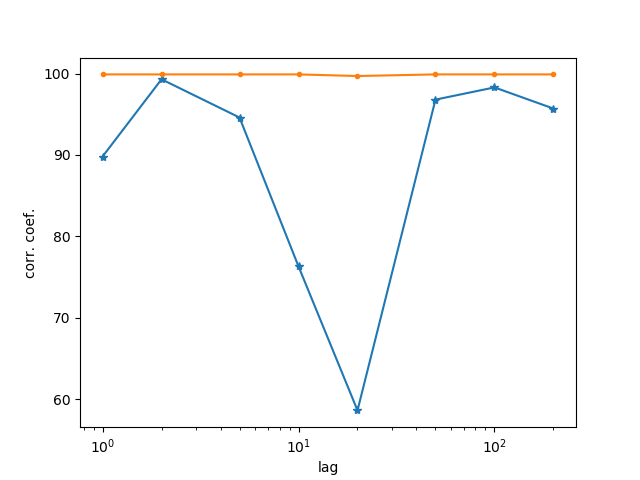

In [158]:
Imag = np.array([89.8, 99.3, 94.6, 76.3, 58.6, 96.8, 98.3, 95.7])
real = np.array([99.9, 99.9, 99.9, 99.9, 99.7, 99.9, 99.9, 99.9])
step_sizes = [1, 2, 5, 10, 20, 50, 100, 200]
plt.figure()
plt.plot(step_sizes, Imag, "*-")
plt.plot(step_sizes, real, ".-")
plt.xscale('log')
plt.xlabel('lag')
plt.ylabel('corr. coef.')
plt.show()

### Calcium from spikes

In [4]:
N = np.shape(spikes)[0]
wup_time = 1000
spikes = spikes[:, wup_time:]
sim_dur = np.shape(spikes)[1]
calcium = np.zeros((N, sim_dur))
tau = 200
dt = 1
const_A = np.exp((-1/tau)*dt)

calcium[:, 0] = spikes[:, 0]

for t in range(1, sim_dur):
    #calcium[:, t] = np.dot(const_A, calcium[:, t-1]) + spikes[:, t]
    calcium[:, t] = const_A*calcium[:, t-1] + spikes[:, t]

In [5]:
np.shape(calcium)

(1250, 5999000)

In [2]:
np.save("calcium-60e6-tau-1.npy", calcium)

NameError: name 'calcium' is not defined

<IPython.core.display.Javascript object>


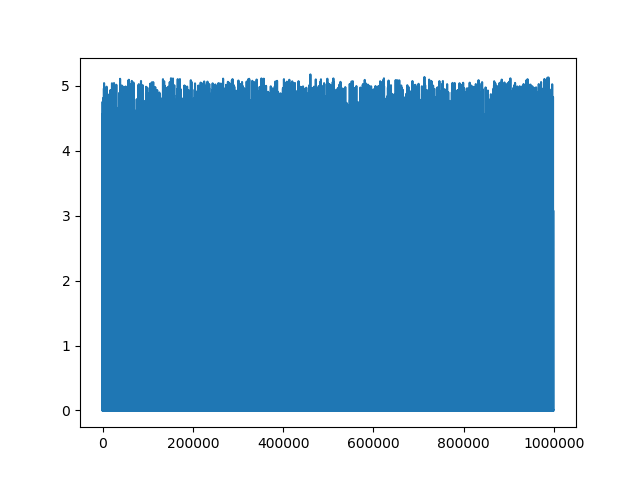

In [118]:
plt.figure()
plt.plot(calcium[10, :])
plt.show()

In [158]:
spikes = calcium[:, 1000:]
del calcium

As the memory and hard disk of kriemhild doesn't allow, I have to do some first estimation process not systematically.

In [2]:
calcium = np.load("calcium-60e6-tau-1.npy")

In [ ]:
Y = spikes[:, :-ds_step]
    Xprime = spikes[:, ds_step:]
    Y_ = np.linalg.pinv(Y)
    del Y
    A = Xprime @ Y_
    del Y_, Xprime

In [3]:
from datetime import datetime
datetime.now()

datetime.datetime(2021, 5, 2, 15, 49, 55, 781440)

In [4]:
ds_step = 100
Y = calcium[:, :-ds_step]
Y_ = np.linalg.pinv(Y)
del Y

from datetime import datetime
datetime.now()

datetime.datetime(2021, 5, 2, 19, 5, 36, 173200)

In [6]:
ds_step

200

In [7]:
Xprime = calcium[:, ds_step:]
A = Xprime @ Y_

In [8]:
np.save("est-60e6-tau1-ds200.npy", A)

In [9]:
G = np.load("connectivity-60e6-ms.npy")
G = G - (np.diag(np.diag(G)))

In [10]:
A = A - (np.diag(np.diag(A)))

In [11]:
np.corrcoef(G.flatten(), A.flatten())[0, 1]

-0.20000104479844846

Block for the erro measurement

In [12]:
G[G == 8.0] = 1.0
G[G == -48.0] = -1.0

A_thresholded = np.copy(A)
A_thresholded[A_thresholded > 0.0042] = 1.0
A_thresholded[A_thresholded < -0.01] = -1.0
A_thresholded[(-0.01 <= A_thresholded) & (A_thresholded <= 0.0042)] = 0.0

confusion_matrix = sklearn.metrics.confusion_matrix(G.flatten(), A_thresholded.flatten(), labels=[1.0, 0.0, -1.0])
confusion_matrix

array([[    348,  118500,       0],
       [  96219, 1317716,       0],
       [   9569,   20148,       0]])

In [13]:
a = 0
for l in range(0, 3):
    a += confusion_matrix[l, l]/(np.sum(confusion_matrix[l, :]))

a

0.9348775983388697

# hiden neuron 

In [54]:
N = 1250
p = 50  #perscentage of observed nodes
K = int((p*N)/100)  #number of observed nodes
R = np.array(random.sample(range(N),K)) #array of random labels

In [6]:
np.save('randm_labels_90.npy', R)

In [5]:
spikes = np.load("calcium-60e6-tau-5.npy")

In [3]:
R = np.load('randm_labels_90.npy')

In [55]:
spikes_partial = spikes[R, :][:]

In [56]:
np.shape(spikes_partial)

(625, 5999000)

In [8]:
np.save('spikes_partial_90.npy', spikes_partial)

In [4]:
spikes_partial = np.load('spikes_partial_90.npy')

In [57]:
from datetime import datetime
datetime.now()

datetime.datetime(2021, 5, 10, 15, 54, 51, 545351)

In [58]:
ds_step = 10
Y = spikes_partial[:, :-ds_step]
Y_ = np.linalg.pinv(Y)
del Y

from datetime import datetime
datetime.now()

datetime.datetime(2021, 5, 10, 16, 41, 9, 949423)

In [59]:
Xprime = spikes_partial[:, ds_step:]
A = Xprime @ Y_

In [60]:
G = np.load('connectivity-60e6-ms.npy')

In [61]:
G_partial = G[R, :][:, R]

In [62]:
G_partial = G_partial - (np.diag(np.diag(G_partial)))
A = A - (np.diag(np.diag(A)))

In [64]:
np.corrcoef(G_partial.flatten(), A.flatten())[0, 1]

0.734473795632554

In [65]:
G_partial[G_partial == 8.0] = 1.0
G_partial[G_partial == -48.0] = -1.0

A_thresholded = np.copy(A)
A_thresholded[A_thresholded > 0.0042] = 1.0
A_thresholded[A_thresholded < -0.01] = -1.0
A_thresholded[(-0.01 <= A_thresholded) & (A_thresholded <= 0.0042)] = 0.0

confusion_matrix = sklearn.metrics.confusion_matrix(G_partial.flatten(), A_thresholded.flatten(), labels=[1.0, 0.0, -1.0])
confusion_matrix

array([[ 25986,   4003,      0],
       [ 71941, 276823,   4700],
       [     0,      1,   7171]])

In [66]:
a = 0
for l in range(0, 3):
    a += confusion_matrix[l, l]/(np.sum(confusion_matrix[l, :]))

a

2.649549987039947

<IPython.core.display.Javascript object>


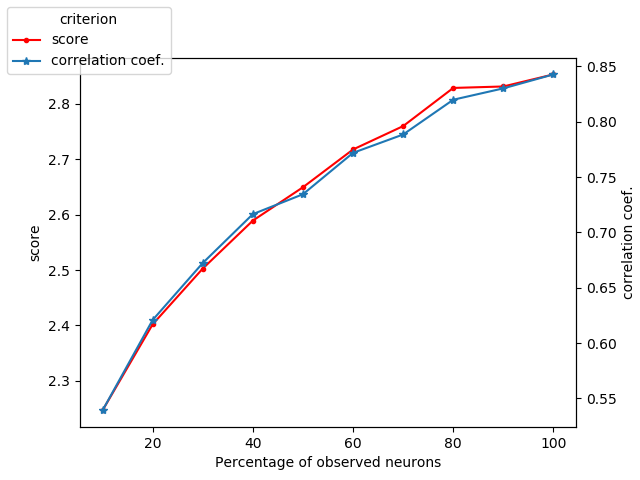

In [72]:
hiden_corr = np.array([0.539247, 0.620877, 0.672366, 0.716509, 0.734473, 0.771857, 0.788433, 0.81983, 0.830096, 0.842708])
hiden_score = np.array([2.246305, 2.401833, 2.502591, 2.589275, 2.649549, 2.717814, 2.760051, 2.829015, 2.831665, 2.853483])
percentages = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

f = plt.figure(1)
ax1 = plt.subplot(111)
ax1.plot(percentages, hiden_score, '.-', color = 'red', label = 'score')
ax2 = ax1.twinx()
ax2.plot(percentages, hiden_corr, '*-', label = 'correlation coef.')
#ax1.set_xscale('log')
ax1.set_xlabel('Percentage of observed neurons')
ax1.set_ylabel('score')
ax2.set_ylabel('correlation coef.')
f.legend(title = 'criterion', loc=2)

In [3]:
rand_labels_1 = np.random.randint(0, 1250, 1250, dtype = int)
#rand_labels_2 = np.random.randint(1, 1251, 1250, dtype = int)
#rand_labels_3 = np.random.randint(1, 1251, 1250, dtype = int)
#rand_labels_4 = np.random.randint(1, 1251, 1250, dtype = int)
#rand_labels_5 = np.random.randint(1, 1251, 1250, dtype = int)

In [5]:
percentage = 70

a = np.shape(rand_labels_1)[0]
b = np.shape(spikes)[1]
partial_spikes = np.zeros((1, b))

partial_labels = rand_labels_1[0:int((percentage/100)*a)] #change the number of random set for error bars
pl_size = np.shape(partial_labels)[0]

for j in np.arange(0, pl_size):
    temp = spikes[partial_labels[j], :].reshape((1, b))
    partial_spikes = np.vstack((partial_spikes, temp))
    
partial_spikes = partial_spikes[1:, :]

In [6]:
np.save('partial_spikes_70.npy', partial_spikes)
np.save('rand_labels_1', rand_labels_1)

In [50]:
del spikes

In [2]:
partial_spikes = np.load("partial_spikes_70.npy")
rand_labels_1 = np.load('rand_labels_1.npy')

In [49]:
np.shape(partial_spikes)

(875, 5999000)

In [51]:
import gc
gc.collect()

1216

In [3]:
from datetime import datetime
datetime.now()

datetime.datetime(2021, 5, 6, 19, 21, 16, 964568)

In [4]:
ds_step = 10
Y = partial_spikes[:, :-ds_step]
Y_ = np.linalg.pinv(Y)
del Y

from datetime import datetime
datetime.now()

datetime.datetime(2021, 5, 6, 20, 9, 8, 339716)

In [5]:
Xprime = partial_spikes[:, ds_step:]
A = Xprime @ Y_

In [12]:
percentage = 70
a = np.shape(rand_labels_1)[0]
#b = np.shape(spikes)[1]
partial_labels = rand_labels_1[0:int((percentage/100)*a)]
pl_size = np.shape(partial_labels)[0]
G = np.load('connectivity-60e6-ms.npy')

gsize = int(1250*(percentage/100))
G_partial_row = np.zeros((1, 1250))
G_partial = np.zeros((gsize, 1))

for j in np.arange(0, pl_size):
    temp = G[partial_labels[j], :].reshape((1, 1250))
    G_partial_row = np.vstack((G_partial_row, temp))
    
G_partial_row = G_partial_row[1:, :]
    
for j in np.arange(0, pl_size):
    temp = G_partial_row[:, partial_labels[j]].reshape((pl_size, 1))
    G_partial = np.hstack((G_partial, temp))

G_partial = G_partial[:, 1:]

In [13]:
G_partial = G_partial - (np.diag(np.diag(G_partial)))
A = A - (np.diag(np.diag(A)))

In [14]:
np.corrcoef(G_partial.flatten(), A.flatten())[0, 1]

6.034025175254336e-12

In [44]:
G_partial[G_partial == 8.0] = 1.0
G_partial[G_partial == -48.0] = -1.0

A_thresholded = np.copy(A)
A_thresholded[A_thresholded > 0.0042] = 1.0
A_thresholded[A_thresholded < -0.01] = -1.0
A_thresholded[(-0.01 <= A_thresholded) & (A_thresholded <= 0.0042)] = 0.0

confusion_matrix = sklearn.metrics.confusion_matrix(G_partial.flatten(), A_thresholded.flatten(), labels=[1.0, 0.0, -1.0])
confusion_matrix

array([[ 13499,   2423,   3232],
       [ 77472, 105880,  43175],
       [   707,      0,   3612]])

In [45]:
a = 0
for l in range(0, 3):
    a += confusion_matrix[l, l]/(np.sum(confusion_matrix[l, :]))

a

2.0084717591244203

In [159]:
#systematic block for downsampling

G = np.load("connectivity-10e6-ms.npy")
G = G - (np.diag(np.diag(G)))

step_sizes = [1, 2, 5, 10, 20, 50, 100, 200]
corr_coef = np.zeros(np.shape(step_sizes))
counter = 0

for ds_step in step_sizes:
    Y = spikes[:, :-ds_step]
    Xprime = spikes[:, ds_step:]
    Y_ = np.linalg.pinv(Y)
    del Y
    A = Xprime @ Y_
    del Y_, Xprime
    A = A - (np.diag(np.diag(A)))
    corr_coef[counter] = np.corrcoef(G.flatten(), A.flatten())[0, 1]
    print(counter)
    counter+=1
    
#corr_coef_tau[counter, :] = corr_coef

0
1
2
3
4
5
6
7


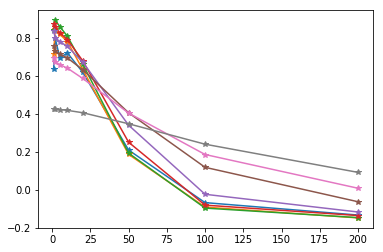

No handles with labels found to put in legend.


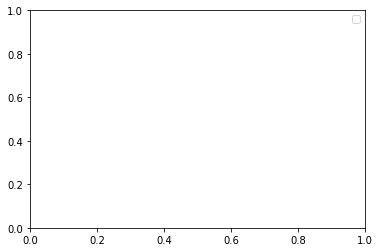

In [5]:
plt.figure()
plt.plot(step_sizes, corr_coef_tau[0, :], "*-", label = "tau = " + str(1))
plt.plot(step_sizes, corr_coef_tau[1, :], "*-", label = "tau = " + str(2))
plt.plot(step_sizes, corr_coef_tau[2, :], "*-", label = "tau = " + str(5))
plt.plot(step_sizes, corr_coef_tau[3, :], "*-", label = "tau = " + str(10))
plt.plot(step_sizes, corr_coef_tau[4, :], "*-", label = "tau = " + str(20))
plt.plot(step_sizes, corr_coef_tau[5, :], "*-", label = "tau = " + str(50))
plt.plot(step_sizes, corr_coef_tau[6, :], "*-", label = "tau = " + str(100))
plt.plot(step_sizes, corr_coef_tau[7, :], "*-", label = "tau = " + str(200))
plt.show()
plt.legend()

<IPython.core.display.Javascript object>


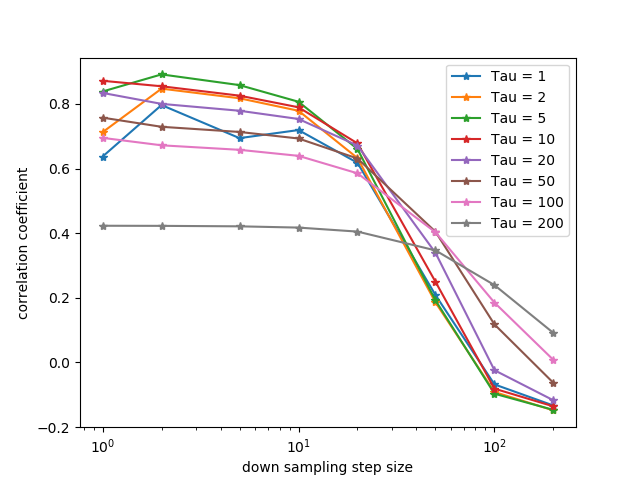

In [166]:
plt.figure()

for i in range(0,8):
    plt.plot(step_sizes, corr_coef_tau[i, :], "*-", label = "Tau = " + str(step_sizes[i]))

plt.xscale('log')
plt.legend()
plt.xlabel('down sampling step size')
plt.ylabel('correlation coefficient')
plt.show()

In [160]:
#corr_coef_tau = np.zeros((8,8))
corr_coef_tau[7, :] = corr_coef
corr_coef_tau

array([[ 0.63708191,  0.79664877,  0.69429525,  0.71928136,  0.61791354,
         0.20855296, -0.06794288, -0.13336063],
       [ 0.71252469,  0.84740996,  0.81760992,  0.77898977,  0.63251441,
         0.1858946 , -0.09150566, -0.14838474],
       [ 0.83857794,  0.89151762,  0.85836778,  0.806837  ,  0.66067664,
         0.19227739, -0.09672766, -0.14685959],
       [ 0.87173378,  0.85477394,  0.82570224,  0.78972449,  0.67806154,
         0.24974497, -0.08112356, -0.1359106 ],
       [ 0.83421441,  0.8002759 ,  0.7790047 ,  0.75355159,  0.67130816,
         0.33935941, -0.02407069, -0.11725506],
       [ 0.75766756,  0.72934958,  0.7133909 ,  0.69313508,  0.63121417,
         0.40466518,  0.11777182, -0.06330875],
       [ 0.69511367,  0.6720722 ,  0.65809132,  0.63945211,  0.58536573,
         0.40291021,  0.18522562,  0.00769816],
       [ 0.42309568,  0.42275662,  0.42129678,  0.41741382,  0.40500661,
         0.34683583,  0.23941637,  0.09119946]])

In [168]:
np.save("corr_coef_tau.npy", corr_coef_tau)

In [4]:
corr_coef_tau = np.load("corr_coef_tau.npy")
step_sizes = [1, 2, 5, 10, 20, 50, 100, 200]

In [94]:
spikes = calcium

In [84]:
del calcium

In [11]:
from datetime import datetime
datetime.now()

datetime.datetime(2020, 11, 12, 22, 23, 35, 753714)

In [3]:
Y = spikes[:, :-1]
Xprime = spikes[:, 1:]
del(spikes)

In [4]:
Y_ = np.linalg.pinv(Y)
del(Y)

In [5]:
A = Xprime @ Y_
#np.save("est-cal-10e6-ms-tau8000.npy", A)

In [88]:
del Y_

In [23]:
G = np.load("connectivity-10e6-ms.npy")

In [21]:
A = np.load("est-cal-10e6-ms-tau2000.npy")

In [89]:
#rough and naive correlation
cf = np.corrcoef(G.flatten(), A.flatten())[0, 1]
cf

0.011435430313641054

In [76]:
datetime.now()

NameError: name 'datetime' is not defined

In [14]:
np.fill_diagonal(A, 0)
np.fill_diagonal(G, 0)
cf = np.corrcoef(G.flatten(), A.flatten())[0, 1]
cf

0.4669379539176601

In [90]:
A = A - (np.diag(np.diag(A)))
G = G - (np.diag(np.diag(G)))
cf = np.corrcoef(G.flatten(), A.flatten())[0, 1]
cf

0.6275584159942652

In [105]:
np.histogram(G.flatten())

(array([  29770,       0,       0,       0,       0,       0,       0,
              0, 1413877,  118853]),
 array([-48. , -42.4, -36.8, -31.2, -25.6, -20. , -14.4,  -8.8,  -3.2,
          2.4,   8. ]))

In [108]:
plt.hist(G.flatten(), bins=100)

(array([   29770.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0

In [23]:
import collections

In [24]:
collections.Counter(G.flatten())

Counter({0.0: 1413877, 8.0: 118853, -48.0: 29770})

# Threshold analysis for unseparated connected/unconnected matrix
## 1- ROC

In [2]:
#load
G = np.load("connectivity-10e7-ms.npy")
A = np.load("est-10e7-ms-bin5.npy")
np.fill_diagonal(A, 0)
np.fill_diagonal(G, 0)
cf = np.corrcoef(G.flatten(), A.flatten())[0, 1]
cf

0.8812507476244223

### 1-a) Threshold for connected/unconnected

<IPython.core.display.Javascript object>


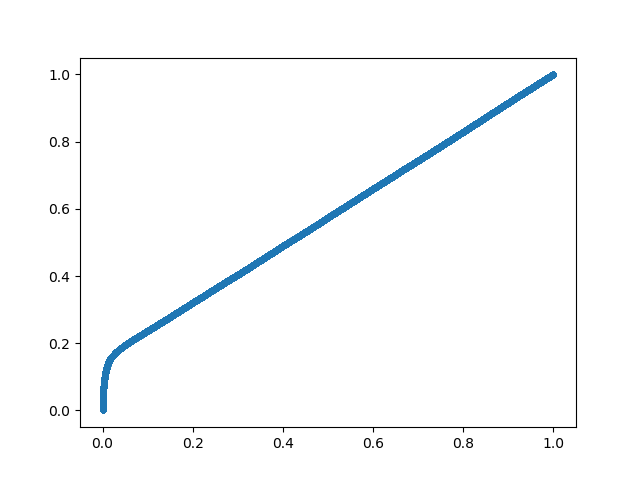

0.574333403572057

In [15]:
#ground truth needs to be binary for conn/unconn analysis
G00_exc = np.copy(G) 
G00_exc[G00_exc != 0] = 1

#without absolut value the inhibitory part would be estimated totaly false, 
#so the maximum of ROC curve would be 0.8
A_abs_exc = abs(A) 

fpr_exc, tpr_exc, tr_exc = sklearn.metrics.roc_curve(G00_exc.flatten(), A_abs_exc.flatten())
plt.figure()
plt.plot(fpr_exc, tpr_exc, ".-")
plt.show()

sklearn.metrics.roc_auc_score(G00_exc.flatten(), A_abs_exc.flatten())

#### finding best threshold and apply

In [20]:
gmeans_exc = scipy.sqrt(tpr_exc * (1 - fpr_exc))
ix_exc = scipy.argmax(gmeans_exc)
print('Best Threshold=%f, G-Mean=%.3f' % (tr_exc[ix_exc], gmeans_exc[ix_exc]))
fpr_unsp[ix_exc]

Best Threshold=0.004515, G-Mean=0.952


0.067776758515769059

In [22]:
A_exc_thresholded = np.copy(A_abs_exc)
A_exc_thresholded[A_exc_thresholded < tr_exc[ix_exc]] = 0
sklearn.metrics.roc_auc_score(G00_exc.flatten(), A_abs_exc.flatten())

0.98472102225005587

### !!!!! classify estimated matrix to have confusion matrix

In [14]:
A_thresholded_binary = np.copy(A_thresholded)
A_thresholded_binary[A_thresholded_binary != 0] = 1
print(sklearn.metrics.roc_auc_score(G00_unseparated.flatten(), A_thresholded_binary.flatten()))
sklearn.metrics.confusion_matrix(G00_unseparated.flatten(), A_thresholded_binary.flatten())

0.85535000517


array([[1320033,   93844],
       [  33132,  115491]])

### 1-b) threshold for exc/unconnected

In [31]:
#load
G = np.load("connectivity-10e7-ms.npy")
A = np.load("est-10e7-ms-bin5.npy")
np.fill_diagonal(A, 0)
np.fill_diagonal(G, 0)
cf = np.corrcoef(G.flatten(), A.flatten())[0, 1]
cf

0.88125074762542899

<IPython.core.display.Javascript object>


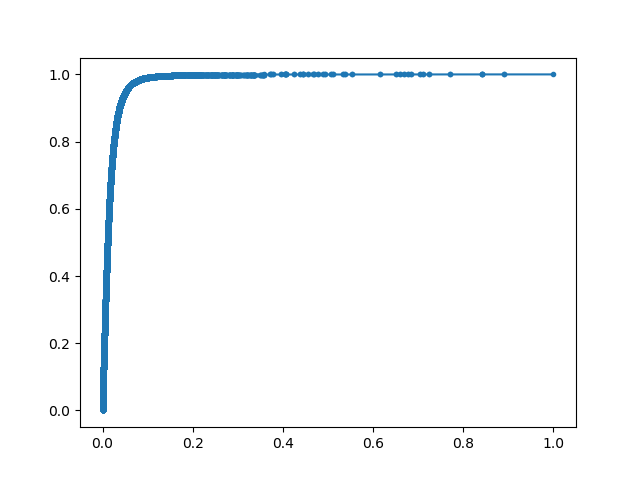

0.98293720695724107

In [35]:
#ground truth needs to be binary for conn/unconn analysis
G00_exc = np.copy(G) 
G00_exc[G00_exc > 0] = 1
G00_exc[G00_exc <= 0] = 0

#without absolut value the inhibitory part would be estimated totaly false, 
#so the maximum of ROC curve would be 0.8
A_abs_exc = abs(A) 

fpr_exc, tpr_exc, tr_exc = sklearn.metrics.roc_curve(G00_exc.flatten(), A.flatten())
plt.figure()
plt.plot(fpr_exc, tpr_exc, ".-")
plt.show()

sklearn.metrics.roc_auc_score(G00_exc.flatten(), A.flatten())

In [38]:
gmeans_exc = scipy.sqrt(tpr_exc * (1 - fpr_exc))
ix_exc = scipy.argmax(gmeans_exc)
print('Best Threshold=%f, G-Mean=%.3f' % (tr_exc[ix_exc], gmeans_exc[ix_exc]))
fpr_exc[ix_exc]

Best Threshold=0.004296, G-Mean=0.953


0.06500481073281765

In [45]:
A_exc_thresholded = np.copy(A_abs_exc)
A_exc_thresholded[A_exc_thresholded < tr_exc[ix_exc]] = 0
sklearn.metrics.roc_auc_score(G00_exc.flatten(), A_exc_thresholded.flatten())

0.94992453971695234

### 1-b) Inhibitory threshold

In [61]:
#load
G = np.load("connectivity-10e7-ms.npy")
A = np.load("est-10e7-ms-bin5.npy")
np.fill_diagonal(A, 0)
np.fill_diagonal(G, 0)
cf = np.corrcoef(G.flatten(), A.flatten())[0, 1]
cf

0.88125074762542899

In [62]:
collections.Counter(G.flatten())

Counter({-48.0: 29770, 0.0: 1413877, 8.0: 118853})

<IPython.core.display.Javascript object>


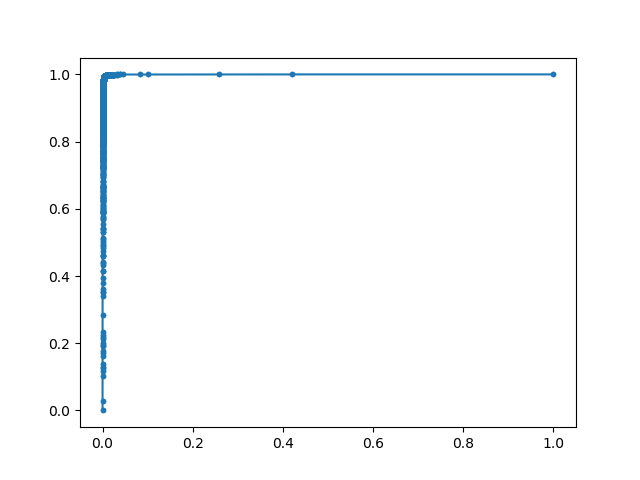

0.99978456929062143

In [42]:
#ground truth needs to be binary for conn/unconn analysis
G00_inh = np.copy(G) 
G00_inh[G00_inh >= 0] = 0
G00_inh[G00_inh < 0] = 1

#without absolut value the inhibitory part would be estimated totaly false, 
#so the maximum of ROC curve would be 0.8
A_abs_inh = abs(A) 

fpr_inh, tpr_inh, tr_inh = sklearn.metrics.roc_curve(G00_inh.flatten(), A_abs_inh.flatten())
plt.figure()
plt.plot(fpr_inh, tpr_inh, ".-")
plt.show()

sklearn.metrics.roc_auc_score(G00_inh.flatten(), A_abs_inh.flatten())

In [43]:
collections.Counter(G00_inh.flatten())

Counter({0.0: 1532730, 1.0: 29770})

In [44]:
gmeans_inh = scipy.sqrt(tpr_inh * (1 - fpr_inh))
ix_inh = scipy.argmax(gmeans_inh)
print('Best Threshold=%f, G-Mean=%.3f' % (tr_inh[ix_inh], gmeans_inh[ix_inh]))
fpr_inh[ix_inh]

Best Threshold=0.014741, G-Mean=0.995


0.0052964318568828172

In [49]:
A_inh_thresholded = np.copy(A_abs_inh)
A_inh_thresholded[A_inh_thresholded > -0.01] = 0
sklearn.metrics.roc_auc_score(G00_exc.flatten(), A_inh_thresholded.flatten())

0.5

## three-class

In [18]:
#load
G = np.load("connectivity-10e7-ms.npy")
A = np.load("est-10e7-ms-bin5.npy")
np.fill_diagonal(A, 0)
np.fill_diagonal(G, 0)
cf = np.corrcoef(G.flatten(), A.flatten())[0, 1]
cf

0.8812507476244223

In [129]:
A_thresholded = np.copy(A)
A_thresholded[A_thresholded > 0.0042] = 8.0
A_thresholded[A_thresholded < -0.01] = -48.0
A_thresholded[(-0.01 <= A_thresholded) & (A_thresholded <= 0.0042)] = 0.0

collections.Counter(A_thresholded.flatten())

Counter({0.0: 1318749, 8.0: 213985, -48.0: 29766})

In [130]:
confusion_matrix = sklearn.metrics.confusion_matrix(G.flatten(), A_thresholded.flatten(), labels=[8.0, 0.0, -48.0])
#confusion_matrix = sklearn.metrics.confusion_matrix(G.flatten(), A_thresholded.flatten())
confusion_matrix

array([[ 115815,    3038,       0],
       [  98170, 1315698,       9],
       [      0,      13,   29757]])

In [128]:
print(sklearn.metrics.classification_report(G.flatten(), A_thresholded.flatten()))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [32]:
a = 0
for l in range(0, 3): a += confusion_matrix[l,l]/(np.sum(confusion_matrix[:, l]))

a

2.538613610781816

In [78]:
test = []
for i in range(1,10):
    for j in range(1,10):
        print(i)
        test[i, j] = i+j
        
test

1


TypeError: list indices must be integers or slices, not tuple

In [115]:
counter_i = 0
counter_j = 0

thresholds_exc = np.arange(-0.0084, 0.0168, 0.0006)
thresholds_inh = np.arange(-0.088, 0.072, 0.004)

acc = np.zeros((43, 40))

for i in thresholds_exc:
    
    counter_j = 0
    
    for j in thresholds_inh:
        
        A_thresholded = np.copy(A)
        A_thresholded[A_thresholded > i] = 8.0
        A_thresholded[A_thresholded < j] = -48.0
        A_thresholded[(j <= A_thresholded) & (A_thresholded <= i)] = 0.0
        
        confusion_matrix = sklearn.metrics.confusion_matrix(G.flatten(), A_thresholded.flatten())
        
        a = 0
        for l in range(0, 3):
            a += confusion_matrix[l,l]/(np.sum(confusion_matrix[l, :]))
            
        acc[counter_i, counter_j] = a
        #acc[counter_i, counter_j] = np.trace(confusion_matrix)
        
        counter_j += 1
        
    counter_i += 1

In [123]:
thresholds_exc = np.arange(-0.0084, 0.0168, 0.0006)
thresholds_inh = np.arange(-0.088, 0.072, 0.004)
thresholds_inh[20]

-0.007999999999999924

<IPython.core.display.Javascript object>


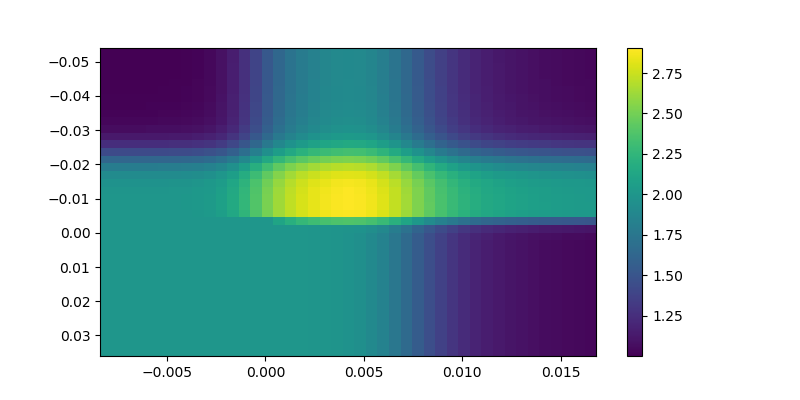

In [92]:
plt.figure(figsize=(8, 4))
plt.imshow(acc.T, interpolation='none', extent=[-0.0084, 0.0168, 0.036, -0.054], aspect='auto')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


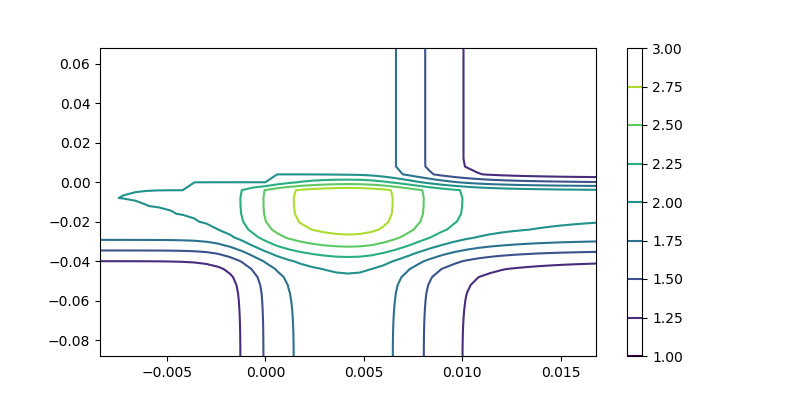

In [93]:
accx = acc_precision[:, :-1]
plt.figure(figsize=(8, 4))
plt.contour(threshodls_exc, thresholds_inh, acc.T)
plt.colorbar()
plt.show()

In [53]:
acc.tolist()

[[1.0271184452058426,
  1.1099871049303975,
  1.4282605345575388,
  1.8363223417459835,
  1.984861139193078,
  1.9998073004631496,
  1.999832045683574,
  1.999832045683574,
  1.999832045683574,
  1.999832045683574,
  0.0],
 [1.0273709424174104,
  1.1102396021419654,
  1.4285130317691066,
  1.8365748389575516,
  1.985113636404646,
  2.0000597976747176,
  1.9998656365468592,
  1.9998656365468592,
  1.9998656365468592,
  1.9998656365468592,
  0.0],
 [1.028326471080795,
  1.1111951308053498,
  1.429468560432491,
  1.837530367620936,
  1.9860691650680304,
  2.001015326338102,
  1.9998992274101446,
  1.9998992274101446,
  1.9998992274101446,
  1.9998992274101446,
  0.0],
 [1.0317638280786101,
  1.114632487803165,
  1.4329059174303063,
  1.8409677246187512,
  1.9895065220658457,
  2.0044526833359173,
  1.9999328182734297,
  1.9999328182734297,
  1.9999328182734297,
  1.9999328182734297,
  0.0],
 [1.0465798269243372,
  1.129448486648892,
  1.4477219162760333,
  1.8557837234644783,
  2.00432252

In [10]:
counter_i = 0
counter_j = 0

thresholds_exc = np.arange(-0.0084, 0.0168, 0.0006)
thresholds_inh = np.arange(-0.088, 0.072, 0.004)

acc = np.zeros((43, 40))

for i in thresholds_exc:
    
    counter_j = 0
    
    for j in thresholds_inh:
        
        A_thresholded = np.copy(A)
        A_thresholded[A_thresholded > i] = 8.0
        A_thresholded[A_thresholded < j] = -48.0
        A_thresholded[(j <= A_thresholded) & (A_thresholded <= i)] = 0.0
        
        confusion_matrix = sklearn.metrics.confusion_matrix(G.flatten(), A_thresholded.flatten())
        
        a = np.trace(confusion_matrix)/np.size(G)
            
        acc[counter_i, counter_j] = a
        
        counter_j += 1
        
    counter_i += 1

In [3]:
np.size(G)

1562500

<IPython.core.display.Javascript object>


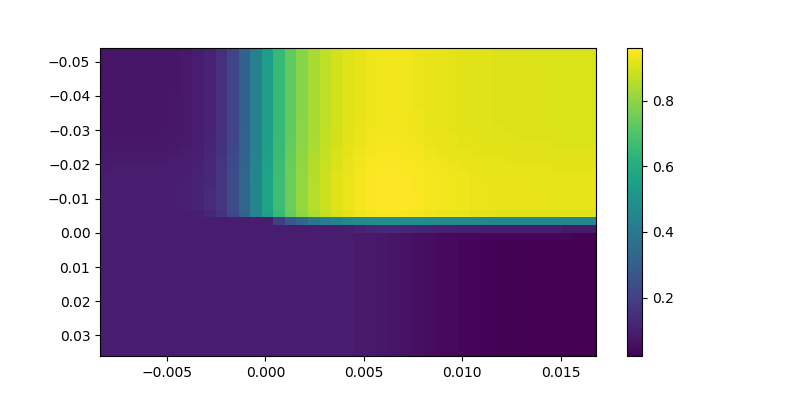

In [11]:
plt.figure(figsize=(8, 4))
plt.imshow(acc.T, interpolation='none', extent=[-0.0084, 0.0168, 0.036, -0.054], aspect='auto')
plt.colorbar()
plt.show()

In [95]:
#my definition for Precision
counter_i = 0
counter_j = 0

thresholds_exc = np.arange(-0.0084, 0.0168, 0.0006)
thresholds_inh = np.arange(-0.088, 0.072, 0.004)

acc_precision = np.zeros((43, 40))


for i in threshodls_exc:
    
    counter_j = 0
    
    for j in thresholds_inh:
        
        A_thresholded = np.copy(A)
        A_thresholded[A_thresholded > i] = 8.0
        A_thresholded[A_thresholded < j] = -48.0
        A_thresholded[(j <= A_thresholded) & (A_thresholded <= i)] = 0.0
        
        confusion_matrix = sklearn.metrics.confusion_matrix(G.flatten(), A_thresholded.flatten())
        
        a = 0.0
        for l in range(0, 3):
            a += confusion_matrix[l,l]/(np.sum(confusion_matrix[:, l]))
            
        acc_precision[counter_i, counter_j] = a
        #acc[counter_i, counter_j] = np.trace(confusion_matrix)
        
        counter_j += 1
        
    counter_i += 1

/opt/hpc/devel/anaconda/2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars


<IPython.core.display.Javascript object>


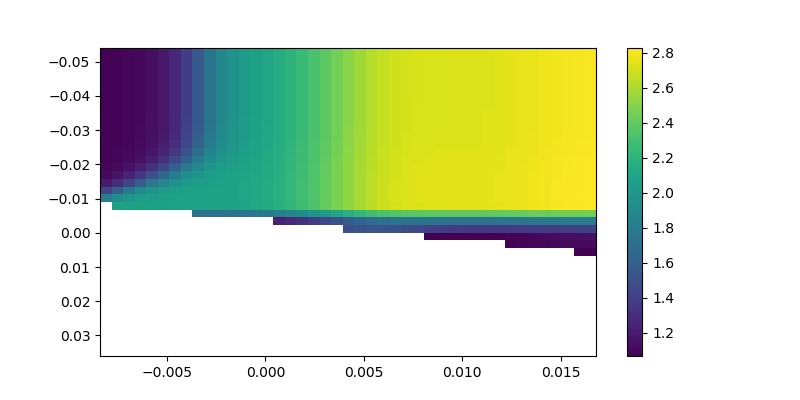

In [97]:
plt.figure(figsize=(8, 4))
plt.imshow(acc_precision.T, interpolation='none', extent=[-0.0084, 0.0168, 0.036, -0.054], aspect='auto')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


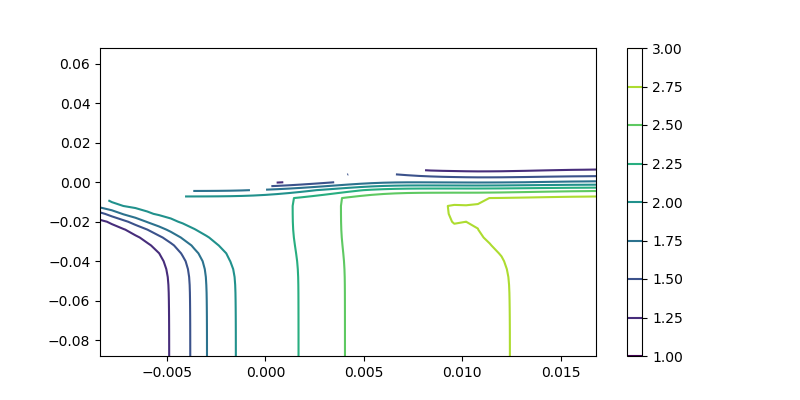

In [100]:
plt.figure(figsize=(8, 4))
plt.contour(threshodls_exc, thresholds_inh, acc_precision.T)
plt.colorbar()
plt.show()

In [105]:
#Stefan's definition

counter_i = 0
counter_j = 0

threshodls_exc = np.arange(-0.0084, 0.0168, 0.0036)
thresholds_inh = np.arange(-0.054, 0.036, 0.009)

acc_sensitivity = np.zeros((7, 10))


for i in threshodls_exc:
    
    counter_j = 0
    
    for j in thresholds_inh:
        
        A_thresholded = np.copy(A)
        A_thresholded[A_thresholded > i] = 8.0
        A_thresholded[A_thresholded < j] = -48.0
        A_thresholded[(j <= A_thresholded) & (A_thresholded <= i)] = 0.0
        
        confusion_matrix = sklearn.metrics.confusion_matrix(G.flatten(), A_thresholded.flatten())
            
        a = confusion_matrix[0,0] + confusion_matrix[0,2] + confusion_matrix[2,0] + confusion_matrix[2,2]
        b = confusion_matrix[0,1] + confusion_matrix[2,0]
            
        acc_sensitivity[counter_i, counter_j] = a/(a+b)
        
        counter_j += 1
        
    counter_i += 1

In [113]:
threshodls_exc

array([-0.0084, -0.0048, -0.0012,  0.0024,  0.006 ,  0.0096,  0.0132])

<IPython.core.display.Javascript object>


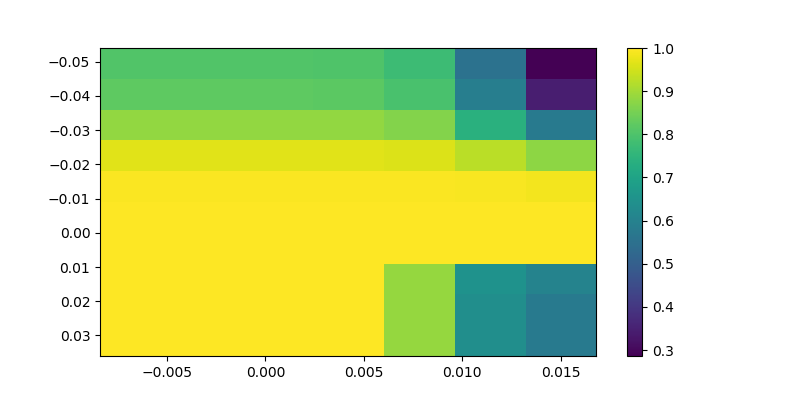

In [106]:
plt.figure(figsize=(8, 4))
plt.imshow(acc_sensitivity.T, interpolation='none', extent=[-0.0084, 0.0168, 0.036, -0.054], aspect='auto')
plt.colorbar()
plt.show()

In [109]:
np.where(acc_sensitivity == 1.0)

(array([0, 0, 0, 0, 1, 1, 1, 1]), array([6, 7, 8, 9, 6, 7, 8, 9]))

In [133]:
A_thresholded = np.copy(A)
A_thresholded[A_thresholded > 0.004199] = 8.0
A_thresholded[A_thresholded < -0.00799] = -48.0
A_thresholded[(-0.00799 <= A_thresholded) & (A_thresholded <= 0.004199)] = 0.0

collections.Counter(A_thresholded.flatten())

Counter({0.0: 1318523, 8.0: 214035, -48.0: 29942})

In [134]:
sklearn.metrics.confusion_matrix(G.flatten(), A_thresholded.flatten(), labels=[8.0, 0.0, -48.0])

array([[ 115816,    3037,       0],
       [  98219, 1315482,     176],
       [      0,       4,   29766]])

# PR

In [ ]:
#ground truth needs to be binary for conn/unconn analysis
G00_exc = np.copy(G) 
G00_exc[G00_exc != 0] = 1

#without absolut value the inhibitory part would be estimated totaly false, 
#so the maximum of ROC curve would be 0.8
A_abs_exc = abs(A) 

fpr_exc, tpr_exc, tr_exc = sklearn.metrics.roc_curve(G00_exc.flatten(), A_abs_exc.flatten())
plt.figure()
plt.plot(fpr_exc, tpr_exc, ".-")
plt.show()

sklearn.metrics.roc_auc_score(G00_exc.flatten(), A_abs_exc.flatten())

In [14]:
precision_con_uncon, recall_con_uncon, tr_con_uncon_pr = sklearn.metrics.precision_recall_curve(G00_exc.flatten(), A_abs_exc.flatten())
sklearn.metrics.average_precision_score(G00_exc.flatten(), A_abs_exc.flatten())

0.8646435801631489

<IPython.core.display.Javascript object>


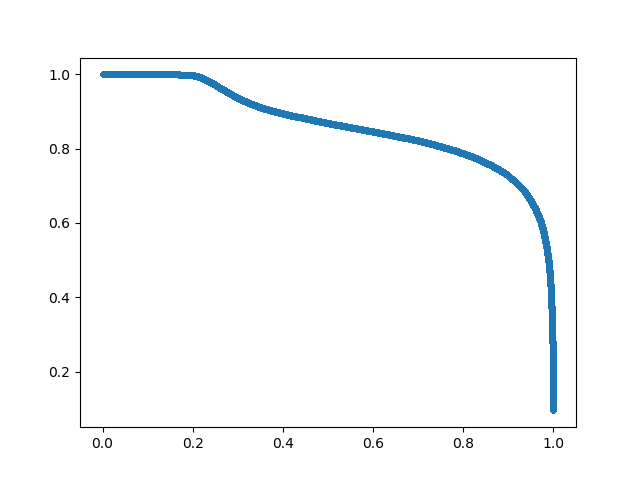

In [15]:
plt.figure()
plt.plot(recall_con_uncon, precision_con_uncon, ".-")
plt.show()

In [82]:
# convert to f score
fscore_unsp = (2 * precision_unsp * recall_unsp) / (precision_unsp + recall_unsp)
# locate the index of the largest f score
ix_unsp_pr = scipy.argmax(fscore_unsp)
print('Best Threshold=%f, F-Score=%.3f' % (tr_unsp_pr[ix_unsp_pr], fscore_unsp[ix_unsp_pr]))

Best Threshold=0.005694, F-Score=0.692


In [83]:
A_thresholded = np.copy(A)
A_thresholded[A_thresholded < tr_unsp_pr[ix_unsp_pr]] = 0
#A_thresholded[A_thresholded != 0] = 1
sklearn.metrics.roc_auc_score(G00_unseparated.flatten(), A_thresholded.flatten())

0.83789394553057694

In [86]:
A_thresholded[A_thresholded != 0] = 1
print(sklearn.metrics.roc_auc_score(G00_unseparated.flatten(), A_thresholded.flatten()))
sklearn.metrics.confusion_matrix(G00_unseparated.flatten(), A_thresholded.flatten())

0.833917490903


array([[1365461,   48416],
       [  44278,  104345]])

In [ ]:
sklearn.metrics.roc_curve(G00_unseparated.flatten(), A_thresholded.flatten(), mult)

In [7]:
A_exc = A[:1000, :1000]
A_inh = A[:, 1000:]

#min_value_exc = scipy.stats.scoreatpercentile(abs(exc.flatten()), 100.-10)
#min_value_inh = scipy.stats.scoreatpercentile(abs(inh.flatten()), 100.-10)

#min_value_exc

In [8]:
G00 = np.copy(G)
G00_exc = G00[:1000, :1000]
G00_exc[G00_exc != 0] = 1

In [33]:
fpr_exc, tpr_exc, tr_exc = sklearn.metrics.roc_curve(G00_exc.flatten(), A_exc.flatten())
plt.figure()
plt.plot(fpr_exc, tpr_exc, ".-")
plt.show()

In [16]:
gmeans_exc = scipy.sqrt(tpr_exc * (1-fpr_exc))
ix_exc = scipy.argmax(gmeans_exc)
print('Best Threshold=%f, G-Mean=%.3f' % (tr_exc[ix_exc], gmeans_exc[ix_exc]))

Best Threshold=0.003752, G-Mean=0.982


In [17]:
fpr_exc[ix_exc]

0.026956128748526226

In [18]:
J_exc = tpr_exc - fpr_exc
ix_exc = scipy.argmax(J_exc)
best_thresh_exc = tr_exc[ix_exc]
print('Best Threshold=%f' % (best_thresh_exc))

Best Threshold=0.003752


In [36]:
#manually finding threshold from 

a = tr_exc[np.where(fpr_exc == 0.0)]
tr_exc
a

array([ 1.04539889,  0.04539889,  0.01988103])

In [19]:
A_exc_thresholded = np.copy(A_exc)
A_exc_thresholded[A_exc_thresholded < best_thresh_exc] = 0
#A_exc_thresholded[A_exc_thresholded != 0] = 1
sklearn.metrics.roc_auc_score(G00_exc.flatten(), A_exc_thresholded.flatten())
#sklearn.metrics.average_precision_score(G00_exc.flatten(), exc.flatten())

0.99230003349543305

In [148]:
np.count_nonzero(A_exc_thresholded)/(1000*1000)*100

10.225900000000001

ValueError: x and y must have same first dimension, but have shapes (25054,) and (270725,)

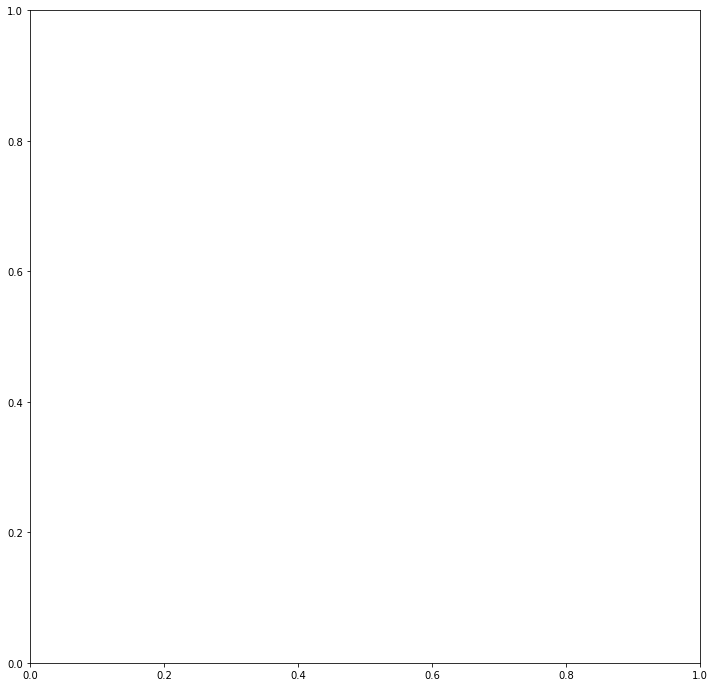

In [151]:
plt.figure(figsize=(12,12))
plt.plot(fpr_exc, tr_exc, ".-")

In [143]:
precision_exc, recall_exc, tr_exc_pr = sklearn.metrics.precision_recall_curve(G00_exc.flatten(), A_exc.flatten())
#prauc = sklearn.metrics.auc(recall10, precision10)
sklearn.metrics.average_precision_score(G00_exc.flatten(), A_exc_thresholded.flatten())

0.9487471813541986

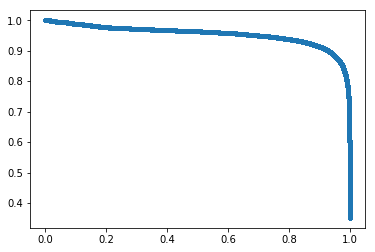

In [144]:
plt.plot(recall_exc, precision_exc, ".-")

In [146]:
# convert to f score
fscore_exc = (2 * precision_exc * recall_exc) / (precision_exc + recall_exc)
# locate the index of the largest f score
ix_exc_pr = scipy.argmax(fscore_exc)
print('Best Threshold=%f, F-Score=%.3f' % (tr_exc_pr[ix_exc_pr], fscore_exc[ix_exc_pr]))

Best Threshold=0.004895, F-Score=0.916


In [147]:
A_exc_thresholded = np.copy(A_exc)
A_exc_thresholded[A_exc_thresholded < tr_exc_pr[ix_exc_pr]] = 0
sklearn.metrics.roc_auc_score(G00_exc.flatten(), A_exc_thresholded.flatten())

0.9724271415740886

<IPython.core.display.Javascript object>


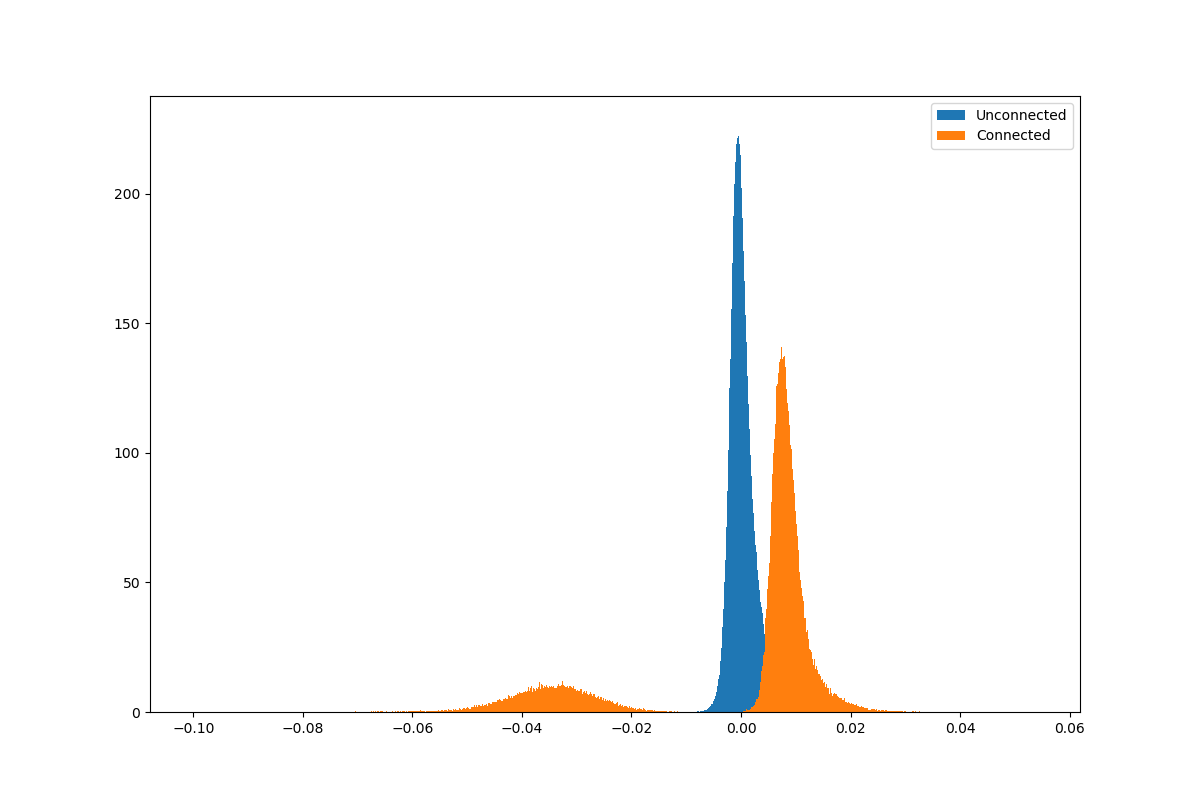

In [13]:
#Decision Making Block

connected = A[G != 0]
unconnected = A[G == 0]

plt.figure(figsize=(12, 8))

plt.hist(unconnected.flatten(), density=True, bins=1000, label='Unconnected')
plt.hist(connected.flatten(), density=True, bins=1000, label='Connected')
#plt.hist(a_negative.flatten(), density=True, bins=100, label='Inhibitory')
plt.legend()
plt.show()

In [25]:
# block for to change threshold manualy

tresholded_exc = np.copy(exc)
#tresholded_inh = np.copy(inh)

min_value_exc = -0.002128
tresholded_exc[abs(exc) < min_value_exc] = 0
tresholded_inh[abs(inh) < min_value_inh] = 0

tresholded_network = np.concatenate((tresholded_exc, tresholded_inh), axis = 1)

cf = np.corrcoef(G.flatten(), tresholded_network.flatten())[0, 1]
cf

0.9109865823383968

In [26]:
np.count_nonzero(tresholded_network.flatten())/(1250*1250)*100

81.93599999999999

In [27]:
G0 = scipy.array(abs(G) > 0)
tresholded_network1 = scipy.array(abs(tresholded_network))
sklearn.metrics.roc_auc_score(G0.flatten(), tresholded_network1.flatten())

0.9946616458158392

In [28]:
np.count_nonzero(tresholded_network1.flatten())/(1250*1250)*100

81.93599999999999

In [29]:
np.count_nonzero(G0.flatten())/(1250*1250)*100

9.511872

In [34]:
#systematic finding the best threshold

counter = 0
auroc = np.zeros((40))
thresholds = np.arange(-0.01, 0.03, 0.001)

for i in thresholds:
    tresholded_exc = np.copy(exc)
    tresholded_inh = np.copy(inh)
    
    min_value_exc = i
    tresholded_exc[abs(exc) < min_value_exc] = 0
    tresholded_inh[abs(inh) < min_value_inh] = 0

    tresholded_network = np.concatenate((tresholded_exc, tresholded_inh), axis = 1)
    
    tresholded_network1 = scipy.array(abs(tresholded_network))
    auroc[counter] = sklearn.metrics.roc_auc_score(G0, tresholded_network1)
    counter += 1

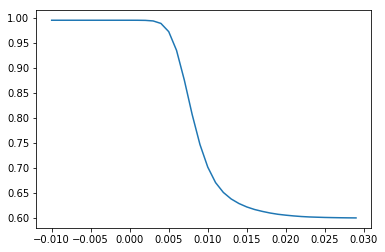

In [36]:
plt.figure
plt.plot(thresholds, auroc)
plt.show()

In [91]:
#plot ROC
fpr10 , tpr10, tr10 = sklearn.metrics.roc_curve(G0.flatten(), tresholded_network1.flatten())
#a, b, c, d = sklearn.metrics.confusion_matrix(G0.flatten(), tresholded_network1.flatten()).ravel()

In [94]:
gmeans = scipy.sqrt(tpr10 * (1-fpr10))
ix = scipy.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (tr10[ix], gmeans[ix]))

Best Threshold=0.005257, G-Mean=0.961


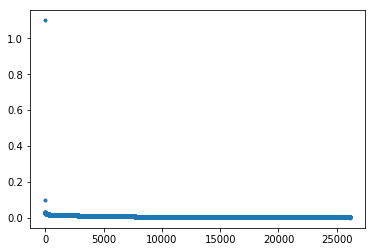

In [74]:
plt.plot(tr0, ".")

In [29]:
fpr_10percent , tpr_10percent, tr_10percent = sklearn.metrics.roc_curve(G0.flatten(), tresholded_network1.flatten())

No handles with labels found to put in legend.


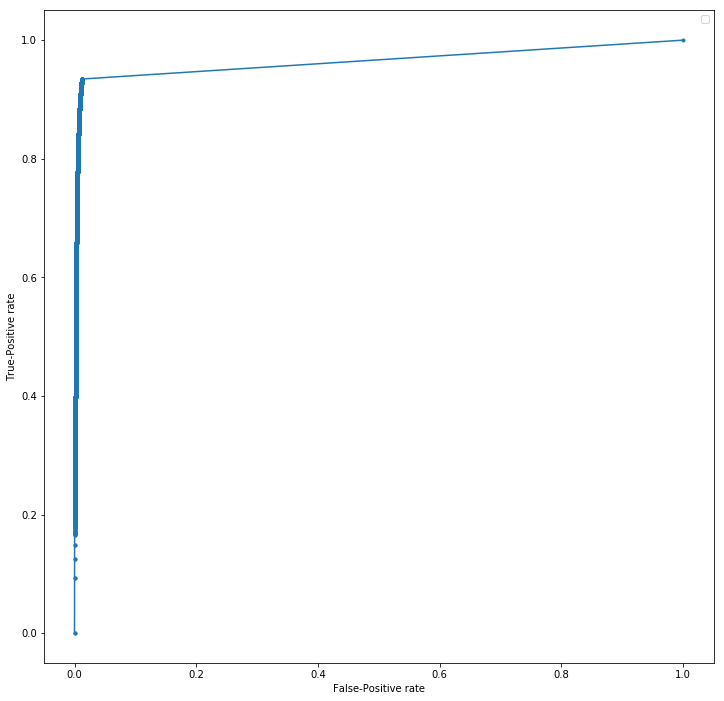

In [78]:
plt.figure(figsize=(12,12))
#plt.plot(fpr0, tpr0, label = "threshold = 0.0")
plt.plot(fpr_10percent, tpr_10percent, ".-")
plt.xlabel("False-Positive rate")
plt.ylabel("True-Positive rate")
plt.legend()
plt.show()

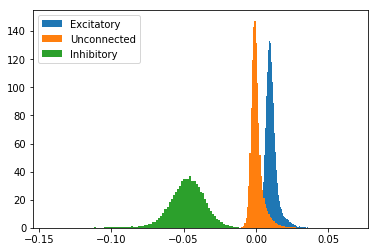

In [40]:
a_positive = A[G > 0]
a_zero = A[G == 0]
a_negative = A[G < 0]


plt.figure()
plt.hist(a_positive.flatten(), density=True, bins=100, label='Excitatory')
plt.hist(a_zero.flatten(), density=True, bins=100, label='Unconnected')
plt.hist(a_negative.flatten(), density=True, bins=100, label='Inhibitory')
plt.legend()
plt.show()

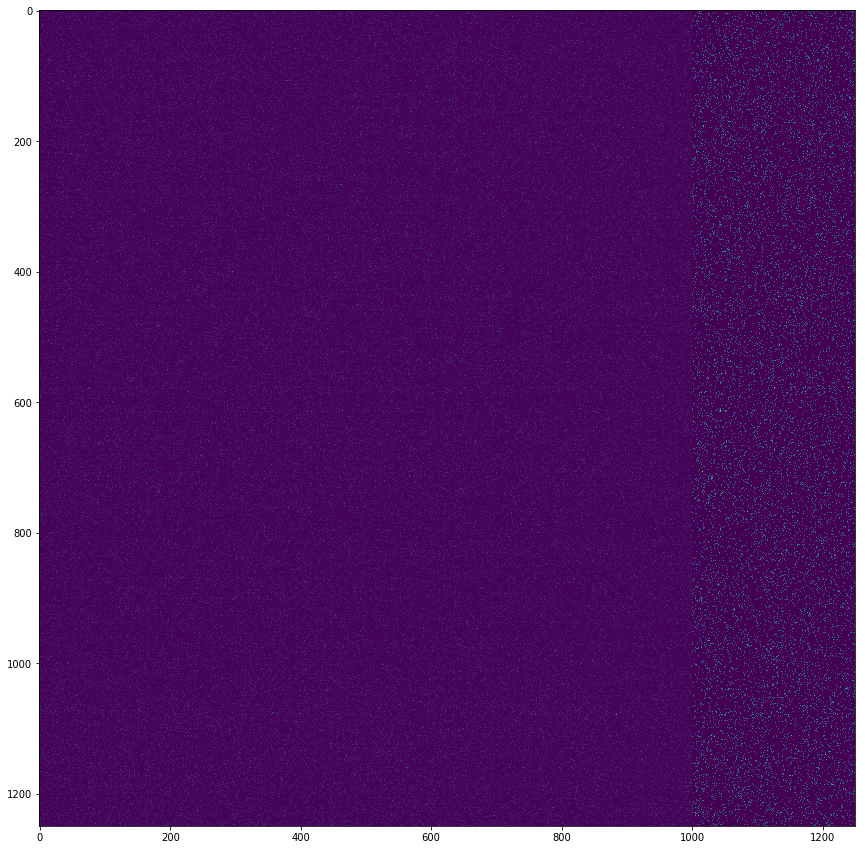

In [38]:
plt.figure(figsize=(15,15))
plt.imshow(tresholded_network1)

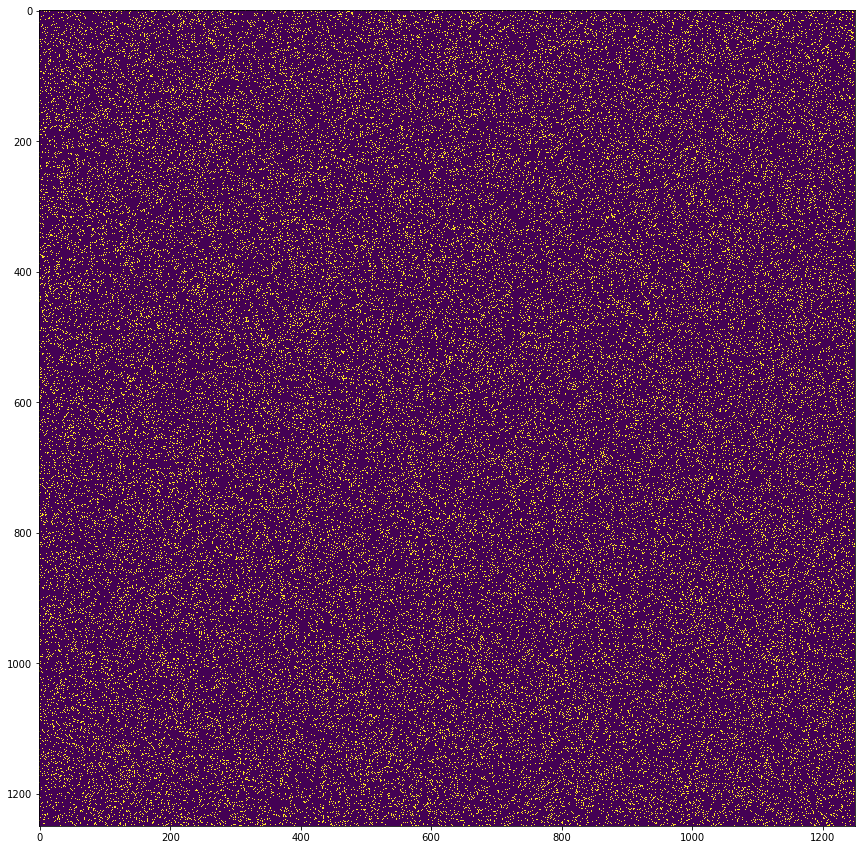

In [39]:
plt.figure(figsize=(15,15))
plt.imshow(G0)

In [18]:
exc_nonzero = tresholded_exc[tresholded_exc != 0]
inh_nonzero = tresholded_inh[tresholded_inh != 0]

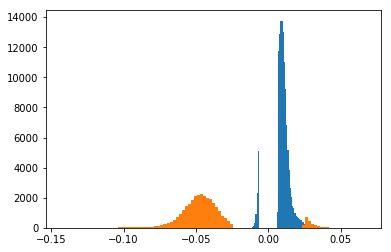

In [19]:
plt.figure()
plt.hist(exc_nonzero.flatten(), bins=100)
plt.hist(inh_nonzero.flatten(), bins=100)
plt.show()

0.9274864961496586

In [31]:
A_exc = A[:, :1000]
A_inh = A[:, 1000:]

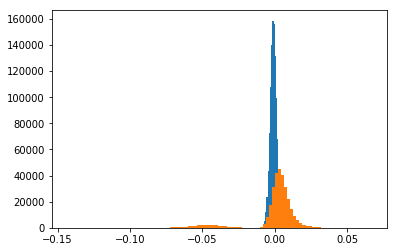

In [33]:
plt.figure()
plt.hist(A_exc.flatten(), bins=100)
plt.hist(A_inh.flatten(), bins=100)
plt.show()

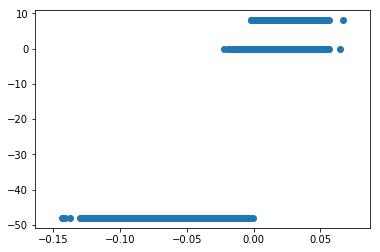

In [34]:
plt.figure()
plt.scatter(A.flatten(), G.flatten())
plt.show()

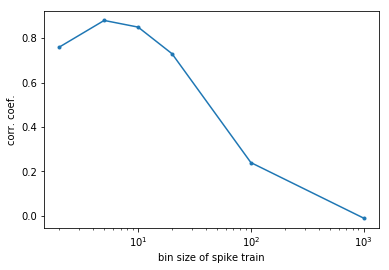

In [44]:
a = [2, 5, 10, 20, 100, 1000]
b = [.76, .88, .85, .73, .24, -0.01]

plt.figure()
plt.plot(a, b, ".-")
plt.xscale("log")
plt.ylabel('corr. coef.')
plt.xlabel('bin size of spike train')
plt.show()